In [8]:
#from pyscf import gto, scf, fci, lo
#import netket as nk; import netket.experimental as nkx
import numpy as np
#import itertools
import qiskit
#from qiskit.quantum_info import Pauli, SparsePauliOp
from collections import defaultdict
#import tensorflow as tf
import sys
import os
import pandas as pd
#import itertools
from itertools import product
import matplotlib.pyplot as plt
#sys.path.append(os.path.dirname(os.getcwd()) + "/SAMPLER_LOCAL_IMPORT")
#from Sampling_Quantum import *
#from New_MCMC_Proposal import *
#sys.path.append(os.getcwd() + "/Code_download_Bell_2")
from MCMC_funs_Leyden import *

print(qiskit.version.get_version_info())
os.getcwd()

ModuleNotFoundError: No module named 'MCMC_funs_Leyden'

In [11]:
os.listdir(os.getcwd())

['bin',
 'chrome_100_percent.pak',
 'chrome_200_percent.pak',
 'Code.exe',
 'Code.VisualElementsManifest.xml',
 'd3dcompiler_47.dll',
 'ffmpeg.dll',
 'icudtl.dat',
 'libEGL.dll',
 'libGLESv2.dll',
 'LICENSES.chromium.html',
 'locales',
 'policies',
 'resources',
 'resources.pak',
 'snapshot_blob.bin',
 'tools',
 'unins000.dat',
 'unins000.exe',
 'unins000.msg',
 'v8_context_snapshot.bin',
 'vk_swiftshader.dll',
 'vk_swiftshader_icd.json',
 'vulkan-1.dll']

In [2]:

from MCMC_funs_Leyden import *

ModuleNotFoundError: No module named 'MCMC_funs_Leyden'

In [100]:
#Cluster_update_scheme (Swedson-Wang /Wolff type + Local Exchange)
#*****************************************************************


def all_configs(n):
    return [np.array(v) for v in product([-1, 1], repeat=n)]



def Sampling_MCMC_trajectories(problem_inst, Transition_matrix, sample_size=10000, 
                               burn=1000, method='Quantum', init_config=None):

    n = problem_inst.n
    beta = problem_inst.T
    prob_dist = np.zeros(2**n)

    #exact_dist = np.exp(-beta * Proposal_object.Energy_array)
    #exact_dist = exact_dist / np.sum(exact_dist)

    #err_hist = []
    key_list = []

    if init_config==None:
        s = np.random.choice([1,-1],size=n)
    else: s = init_config

    int_key = spinconf2int(s)
    #print(int_key)
    
    for k in range(burn):
        #s = Proposal_object.generate_MCMC_trajectories(Transition_matrix, s)
         int_key = generate_move(transition_mat=Transition_matrix, state=int_key)

    for k in range(sample_size):
        #s = Proposal_object.generate_MCMC_trajectories(Transition_matrix, s)
        int_key = generate_move(transition_mat=Transition_matrix, state=int_key)
        #key = spinconf2int(s)
        prob_dist[int_key] +=1
        key_list.append(int_key)

    
    return np.flip(prob_dist/np.sum(prob_dist)), key_list



def wolff_clustering_flipping_step(v, beta, J, h=None, num_trials=200):
    from collections import defaultdict
    n = len(v)
    counts = defaultdict(int)

    for i in range(n):  # Seed spin
        for _ in range(num_trials):
            visited = np.zeros(n, dtype=bool)
            cluster = [i]
            visited[i] = True

            while cluster:
                j = cluster.pop()
                for k in range(n):
                    if not visited[k] and v[k] == v[j] and J[j, k] != 0:
                        p_add = 1 - np.exp(-2 * beta * J[j, k])
                        if np.random.rand() < p_add:
                            visited[k] = True
                            cluster.append(k)

            v_new = v.copy()
            v_new[visited] *= -1
            counts[tuple(v_new)] += 1

    total = n * num_trials
    return {k: c / total for k, c in counts.items()}


def Wolff_cluster_Proposal_matrix(problem_inst):

    J_Q = problem_inst.J_quantum
    h_Q = problem_inst.h_quantum
    n = problem_inst.n
    beta = problem_inst.T
    #print(beta)
    configs = all_configs(n)
    index = {tuple(c): i for i, c in enumerate(configs)}

    Q = np.zeros((2**n, 2**n))

    for v in configs:
        prop_probs = wolff_clustering_flipping_step(v, beta=beta, J=J_Q, h=h_Q, num_trials=200)
        i = index[tuple(v)]
        for v_prime, prob in prop_probs.items():
            j = index[v_prime]
            if j != i :
                Q[j, i] = abs(prob)
        
        Q[i, i] = abs(1- sum(Q[:,i]))

    return Q






#Continuous variable encoding (Hamiltonian Monte Carlo, Adaptive MCMC)
#*********************************************************************


def normalize_transition_matrix(T, eps=1e-12, verbose=False):
   
    T = np.copy(T)  
    T[T < 0] = 0.0  

    for j in range(T.shape[1]):
        col_sum = T[:, j].sum()
        if abs(col_sum) > eps:
            T[:, j] /= abs(col_sum)
        else:
            # Uniform fallback for ill-defined columns
            T[:, j] = 1.0 / T.shape[0]
            if verbose:
                print(f"Warning: column {j} had zero or near-zero sum. Reset to uniform.")

    # Validate after normalization
    if verbose:
        for j in range(T.shape[1]):
            if not np.isclose(T[:, j].sum(), 1.0, atol=1e-6):
                print(f"Column {j} sum = {T[:, j].sum()} (should be 1.0)")
            if np.any(T[:, j] < 0):
                print(f"Negative entries found in column {j}: {T[:, j][T[:, j] < 0]}")

    return T



def grad_U(x, J, h, alpha):
    v = np.sign(np.tanh(alpha * x))
    sech_sq = 1.0 * (1 - v ** 2)
    return alpha * sech_sq * (h + 2 * J @ v)



def leapfrog_integrator(x, p, grad_U, epsilon, L, J, h, alpha):
    # Integrates hamilton's eqn of motion
    x_new = np.copy(x)
    p_new = np.copy(p) - 0.5 * epsilon * grad_U(x_new, J, h, alpha)
    for _ in range(L):
        x_new += epsilon * p_new
        if _ != L - 1:
            p_new -= epsilon * grad_U(x_new, J, h, alpha)
    p_new -= 0.5 * epsilon * grad_U(x_new, J, h, alpha)
    return x_new, p_new



def HMC_step(v, problem_inst, epsilon, L, alpha=2.0, num_p_samples=10):
    """HMC update for binary v using multiple momentum samples"""
    J_Q = problem_inst.J_quantum
    h_Q = problem_inst.h_quantum
    n = problem_inst.n
    beta = problem_inst.T
    
    x = np.arctanh(np.clip(v, -0.999, 0.999)) / alpha
    counts = {}

    for _ in range(num_p_samples):
        p = np.random.normal(size=n)


        v_old = np.sign(np.tanh(alpha * x))
        
        #U_x_init = config_energies[2**n - Proposal_object.get_spinconfig_to_int(v_old)-1]
        U_x_init = problem_inst.E_arr[::-1][spinconf2int(v_old)]
        H_init = 0.5 * np.sum(p**2) + U_x_init

        
        x_new, p_new = leapfrog_integrator(x, p, grad_U, epsilon, L, J_Q, h_Q, alpha)
        v_new = np.sign(np.tanh(alpha * x_new))

        #U_x_final = config_energies[2**n - Proposal_object.get_spinconfig_to_int(v_new)-1]    #changes all -1 to 0 and 1 to 1 

        U_x_final = problem_inst.E_arr[::-1][spinconf2int(v_new)]
        H_final = 0.5 * np.sum(p_new**2) + U_x_final

        accept_prob = min(1.0, np.exp(-(beta*H_final - beta*H_init)))

        
        if np.random.rand() < accept_prob:
            v_tuple = tuple(v_new.astype(int))
        else:
            v_tuple = tuple(v.astype(int))

        counts[v_tuple] = counts.get(v_tuple, 0) + 1

    return counts


def HMC_T_matrix(problem_inst, epsilon=0.1, L=10, alpha=3.0, num_samples=100, num_p_samples=10):

    from tqdm import tqdm
    J_Q = problem_inst.J_quantum
    h_Q = problem_inst.h_quantum
    n = problem_inst.n
    beta = problem_inst.T
    
    configs = all_configs(n)
    idx_map = {tuple(c): i for i, c in enumerate(configs)}
    T = np.zeros((2**n, 2**n))

    for v in tqdm(configs, desc="Building T matrix"):
        aggregate_counts = {}
        for _ in range(num_samples):
            counts = HMC_step(np.array(v),problem_inst, epsilon, L, alpha, num_p_samples)
            for k, val in counts.items():
                aggregate_counts[k] = aggregate_counts.get(k, 0) + val

        i = idx_map[tuple(v)]
        total = sum(aggregate_counts.values())
        for v_prime, c in aggregate_counts.items():
            
            j = idx_map[v_prime]
            if j != i :
                T[j, i] = c / total
            #if j != i:
            #    T[i, j] = c / total

            #else:
        T[i,i] = 1-sum(T[:,i])       

    T = normalize_transition_matrix(T, eps=1e-12, verbose=True)
    
    # T[T < 0] = 0
    # # T = T / T.sum(axis=0, keepdims=True)

    # for i in range(T.shape[1]):
    #     col_sum = T[:, i].sum()
    #     if col_sum > 0:
    #         T[:, i] /= col_sum
    #     else:
    #         T[:, i] = 1.0 / T.shape[0]

    return T


def adaptive_MALA_step(x, cov, epsilon, problem_inst, alpha=3.0):
    J_Q = problem_inst.J_quantum
    h_Q = problem_inst.h_quantum
    
    P = np.linalg.cholesky(cov + 1e-6 * np.eye(len(x)))
    eta = np.random.normal(size=len(x))
    
    
    v = np.sign(np.tanh(alpha * x))
    #E_old = energy(v, J, h)
    E_old = problem_inst.E_arr[::-1][spinconf2int(v)]
    

    x_new = x - 0.5 * epsilon**2 * np.linalg.inv(cov + 1e-6 * np.eye(len(x))) @ grad_U(x, J_Q, h_Q, alpha) + epsilon * P @ eta
    v_new = np.sign(np.tanh(alpha * x_new))
    E_new = problem_inst.E_arr[::-1][spinconf2int(v_new)]
    

    acc_prob = min(1.0, np.exp(-problem_inst.T * (E_new - E_old)))
    if np.random.rand() < acc_prob:
        return x_new, v_new
    else:
        return x, v


def adaptive_MALA_T_matrix(problem_inst, alpha=3.0, epsilon=0.3, num_samples=500):
    from tqdm import tqdm
    
    n = problem_inst.n
    #beta = problem_inst.T
    
    configs = all_configs(n)
    idx_map = {tuple(c): i for i, c in enumerate(configs)}
    T = np.zeros((2**n, 2**n))

    for v in tqdm(configs, desc="Building T matrix"):
        x = np.arctanh(np.clip(v, -0.999, 0.999)) / alpha
        cov = np.eye(n)
        
        counts = defaultdict(int)

        v_samples = []
        adapt_window = 5

        for step in range(num_samples):
            x, v_new = adaptive_MALA_step(x, cov, epsilon, problem_inst, alpha=3.0)
            v_samples.append(v_new)

            key = tuple(v_new.astype(int))
            counts[key] = counts.get(key, 0) + 1

            if (step + 1) % adapt_window == 0 and step > 0:
                if len(v_samples) >= 50:
                    x_hist = np.array([np.arctanh(np.clip(np.tanh(alpha * x0), -0.999, 0.999)) / alpha for x0 in v_samples[-50:]])
                    
                else:
                    x_hist = np.array([np.arctanh(np.clip(np.tanh(alpha * x0), -0.999, 0.999)) / alpha for x0 in v_samples])

                cov = np.cov(x_hist.T) 
                
        i = idx_map[tuple(v)]
        total = sum(counts.values())
        
        for v_prime, c in counts.items():
            j = idx_map[v_prime]
            
            if j != i :
                T[j, i] = c / total
            #if j != i:
            #    T[i, j] = c / total

            #else:
        T[i,i] = 1-sum(T[:,i])  
        
    T = normalize_transition_matrix(T, eps=1e-12, verbose=True)
    # T[T < 0] = 0
    # # T = T / T.sum(axis=0, keepdims=True)

    # for i in range(T.shape[1]):
    #     col_sum = T[:, i].sum()
    #     if col_sum > 0:
    #         T[:, i] /= col_sum
    #     else:
    #         T[:, i] = 1.0 / T.shape[0]

    return T



def adaptive_metropolis_step(x, cov, epsilon, problem_inst, alpha=3.0):
    """Performs one Adaptive Metropolis-Hastings step."""
    P = np.linalg.cholesky(cov + 1e-6 * np.eye(len(x)))   #pre-conditioner matrix
    eta = np.random.normal(size=len(x))   # normally distributed noise sample

    v_old = np.sign(np.tanh(alpha * x))
    E_old = problem_inst.E_arr[::-1][spinconf2int(v_old)]
    
    x_new = x + epsilon * P @ eta
    v_new = np.sign(np.tanh(alpha * x_new))
    E_new = problem_inst.E_arr[::-1][spinconf2int(v_new)]
    
    #E_old = energy_tanh(x, J, h, alpha)
    #E_new = energy_tanh(x_prop, J, h, alpha)
    
    accept_prob = min(1.0, np.exp(-problem_inst.T * (E_new - E_old)))
    if np.random.rand() < accept_prob:
        return x_new, True
    else:
        return x, False


def adaptive_metropolis_T_matrix(problem_inst, alpha=3.0, epsilon=0.05, num_samples=500):
    """Builds the transition matrix using Adaptive Metropolis-Hastings for Ising spins."""
    from tqdm import tqdm
    J_Q = problem_inst.J_quantum
    h_Q = problem_inst.h_quantum
    n = problem_inst.n
    beta = problem_inst.T
    
    configs = all_configs(n)
    idx_map = {tuple(c): i for i, c in enumerate(configs)}
    T = np.zeros((2**n, 2**n))

    for v in tqdm(configs, desc="Building T matrix"):
        x = np.arctanh(np.clip(v, -0.999, 0.999)) / alpha
        cov = np.eye(n)
        counts = defaultdict(int)

        x_samples = []
        adapt_window = 5
        
        for step in range(num_samples):
            x, _ = adaptive_metropolis_step(x, cov, epsilon, problem_inst, alpha)
            x_samples.append(x.copy())
            
            v_new = tuple(np.sign(np.tanh(alpha * x)).astype(int))
            counts[v_new] = counts.get(v_new, 0) + 1


            #if (step + 1) % adapt_window == 0 and len(x_samples) > 1:
            if (step + 1) % adapt_window == 0 and step > 0:
                if len(x_samples) >= 50:
                    x_array = np.stack(x_samples[-50:])

                else:
                    x_array = np.stack(x_samples)
                    
                cov = np.cov(x_array.T)
                #x_samples = []  # reset buffer


        i = idx_map[tuple(v)]
        total = sum(counts.values())
        
        for v_prime, c in counts.items():
            j = idx_map[v_prime]
            
            if j != i :
                T[j, i] = c / total
            #if j != i:
            #    T[i, j] = c / total

            #else:
        T[i,i] = 1-sum(T[:,i])       

    T = normalize_transition_matrix(T, eps=1e-12, verbose=True)
    
    # T[T < 0] = 0
    # # T = T / T.sum(axis=0, keepdims=True)

    # for i in range(T.shape[1]):
    #     col_sum = T[:, i].sum()
    #     if col_sum > 0:
    #         T[:, i] /= col_sum
    #     else:
    #         T[:, i] = 1.0 / T.shape[0]

    return T




Starting problem instance 1 of 5 with n = 3


/var/folders/6j/km5pgqd14476f6rtx6cbp9y80000gn/T/ipykernel_84034/4055241133.py:114: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results,pd.DataFrame([results_datum])], ignore_index=True)


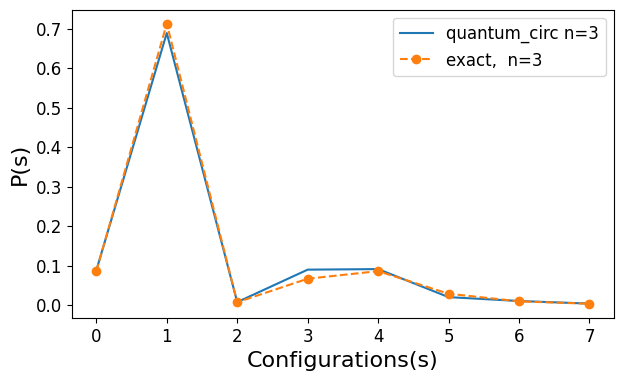

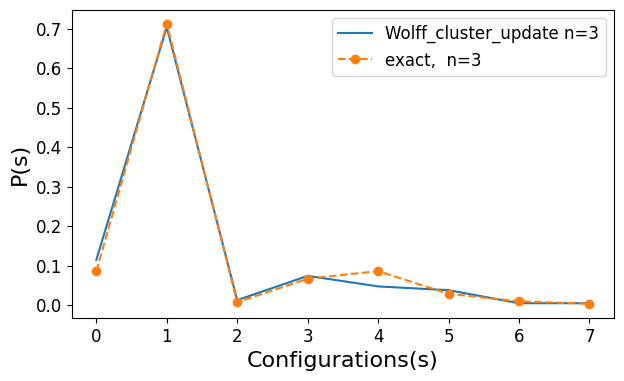

Building T matrix: 100%|██████████████████████████| 8/8 [00:07<00:00,  1.13it/s]


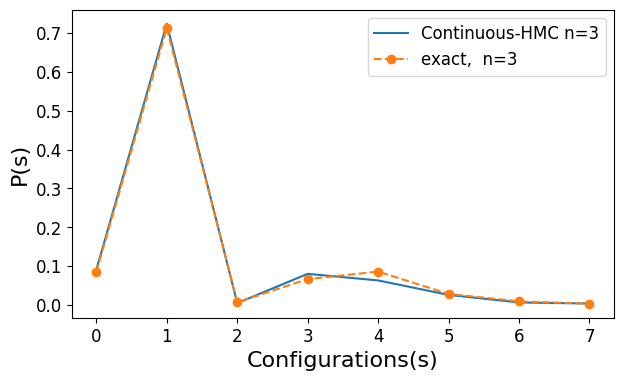

Building T matrix: 100%|██████████████████████████| 8/8 [00:00<00:00, 40.88it/s]


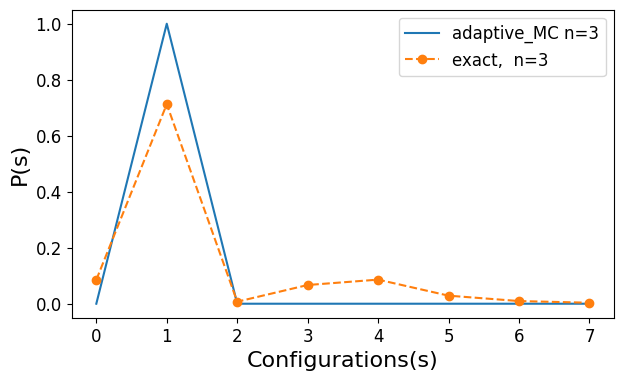

Building T matrix: 100%|██████████████████████████| 8/8 [00:00<00:00, 14.31it/s]


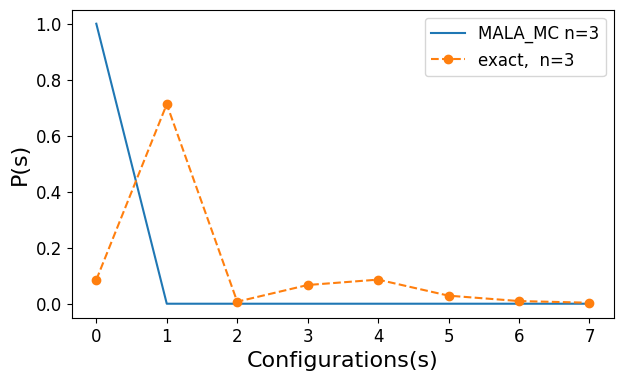

Starting problem instance 2 of 5 with n = 4


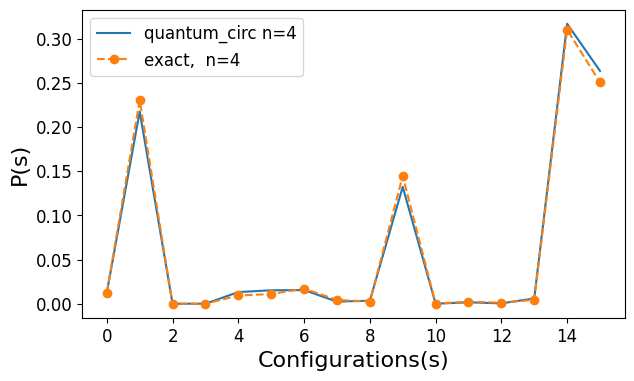

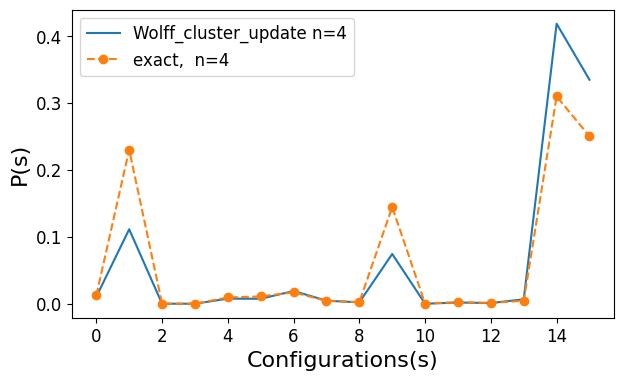

Building T matrix: 100%|████████████████████████| 16/16 [00:14<00:00,  1.13it/s]


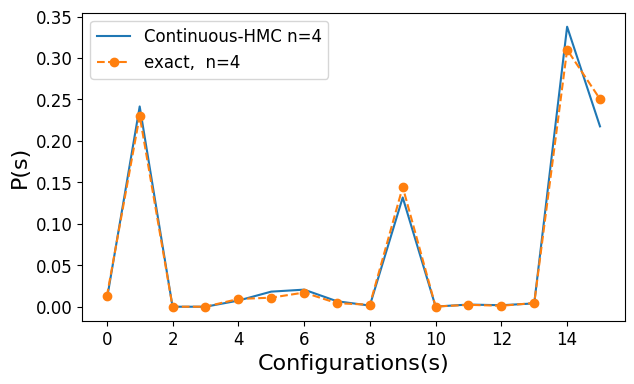

Building T matrix: 100%|████████████████████████| 16/16 [00:00<00:00, 44.01it/s]


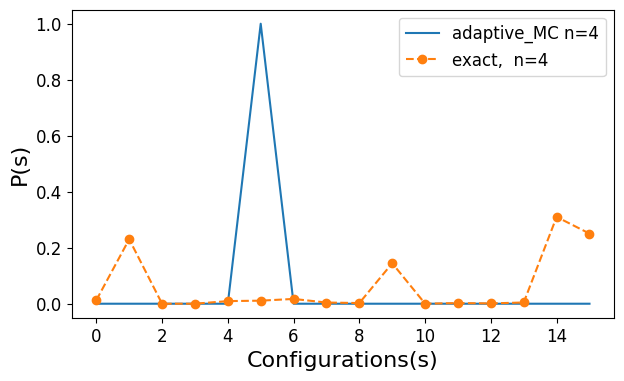

Building T matrix: 100%|████████████████████████| 16/16 [00:01<00:00, 12.56it/s]


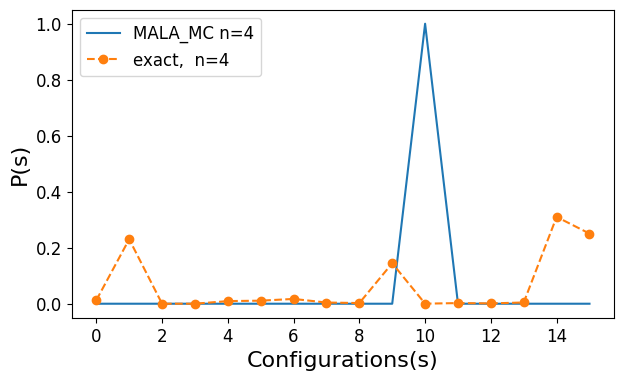

Starting problem instance 3 of 5 with n = 5


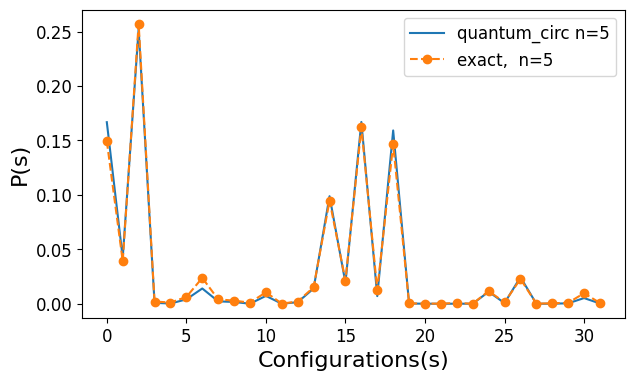

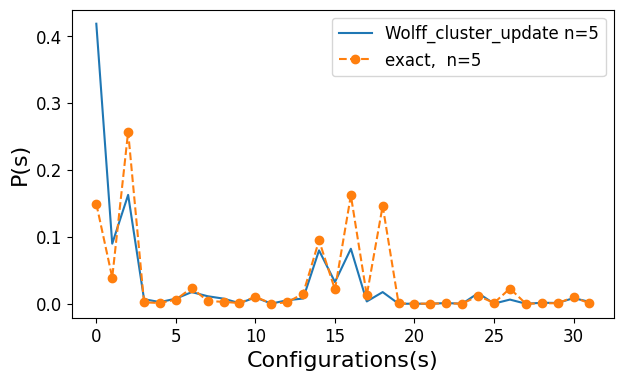

Building T matrix: 100%|████████████████████████| 32/32 [00:32<00:00,  1.01s/it]


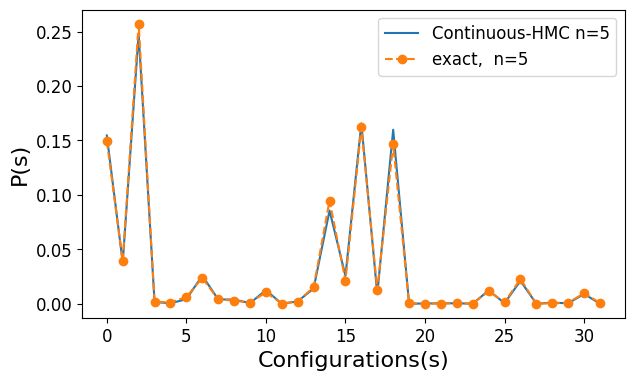

Building T matrix: 100%|████████████████████████| 32/32 [00:00<00:00, 43.24it/s]


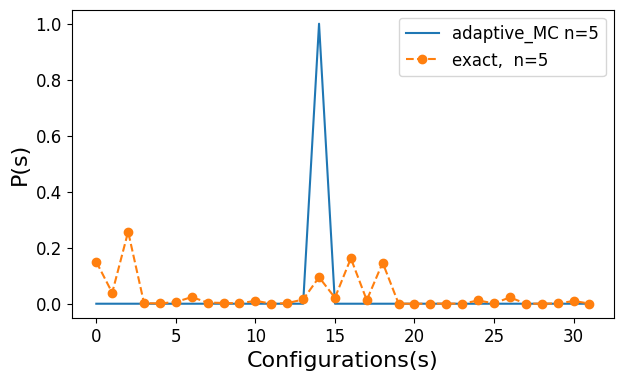

Building T matrix: 100%|████████████████████████| 32/32 [00:03<00:00,  9.93it/s]


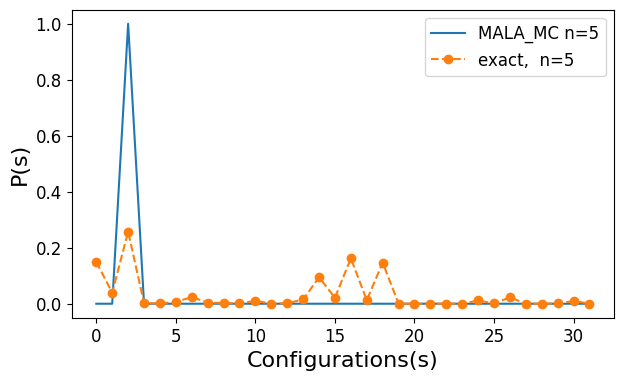

Starting problem instance 4 of 5 with n = 6


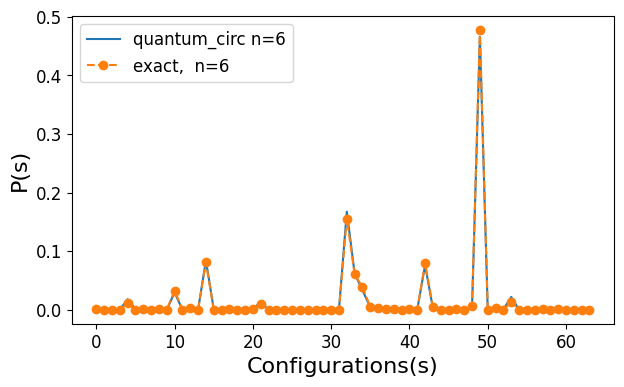

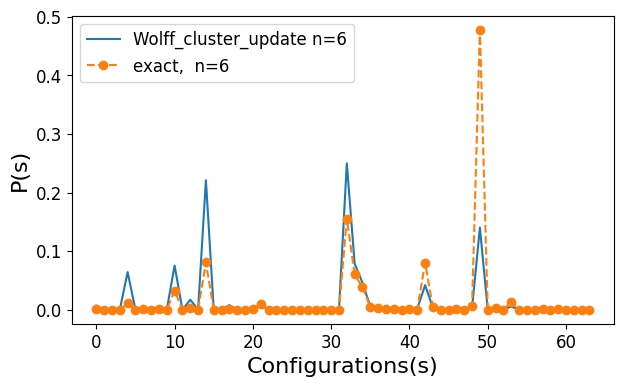

Building T matrix: 100%|████████████████████████| 64/64 [00:56<00:00,  1.13it/s]


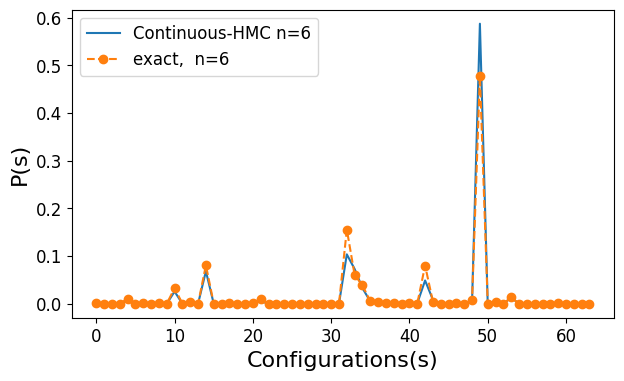

Building T matrix: 100%|████████████████████████| 64/64 [00:01<00:00, 44.41it/s]


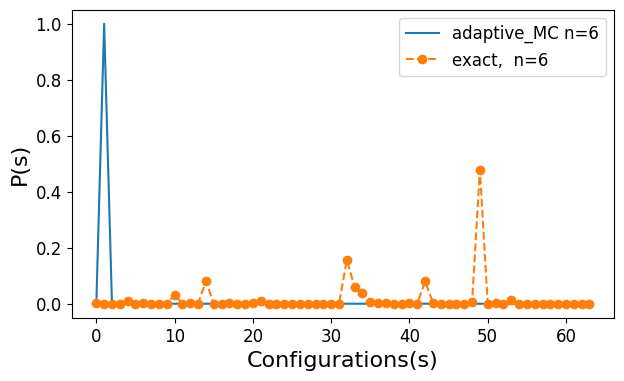

Building T matrix: 100%|████████████████████████| 64/64 [00:07<00:00,  8.56it/s]


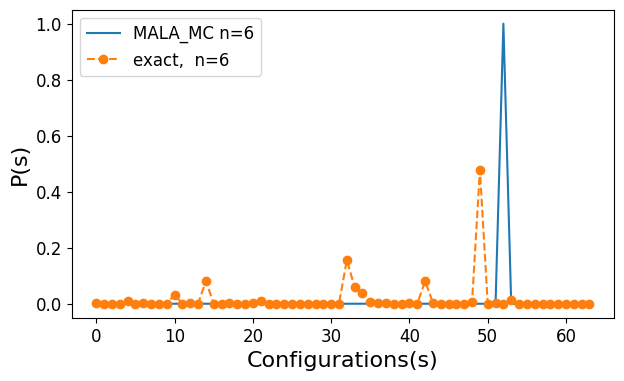

Starting problem instance 5 of 5 with n = 7


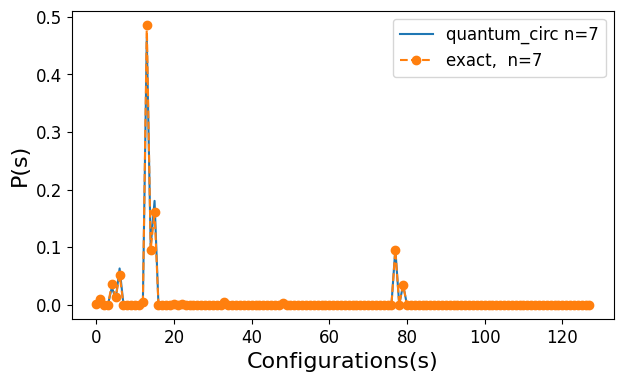

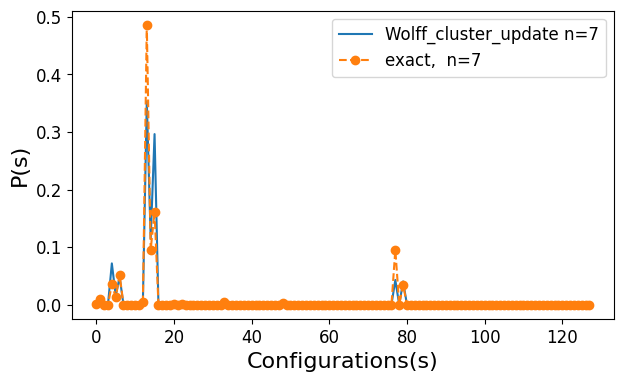

Building T matrix: 100%|██████████████████████| 128/128 [01:53<00:00,  1.13it/s]


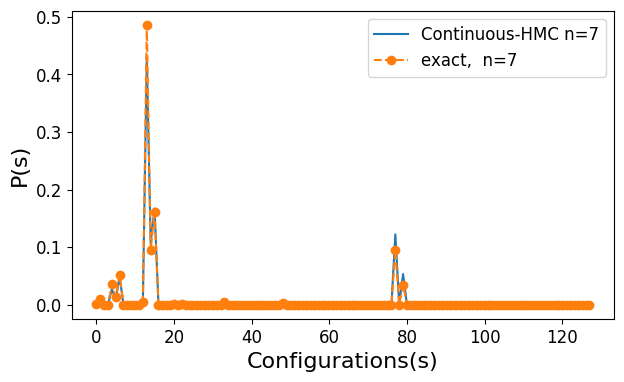

Building T matrix: 100%|██████████████████████| 128/128 [00:02<00:00, 44.18it/s]


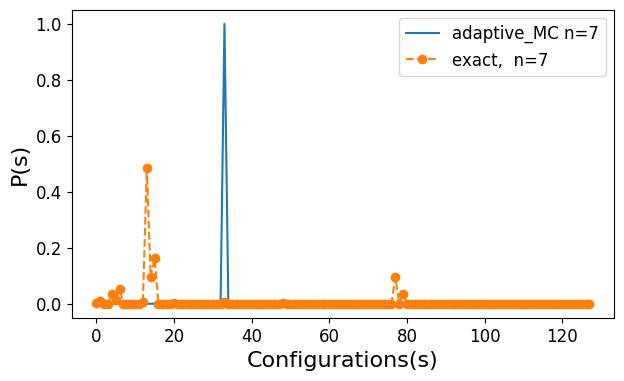

Building T matrix: 100%|██████████████████████| 128/128 [00:17<00:00,  7.49it/s]


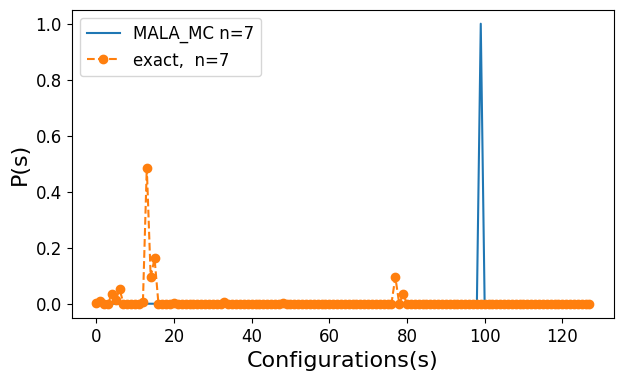

In [107]:

def instance_result_reader_writer(filepath, filename_instances, sample_size=1000):
    from tqdm import tqdm
    instances = pd.read_pickle(filepath + filename_instances)
    #tot_instances = np.max(instances['Instance Number'].values)
    tot_instances = 5
    results = pd.DataFrame(columns = [
        'Instance Number',
        'Spins', 
        'Temperature', 
        'Connectivity',
        'Proposal',
        'Acceptance',
#    'Mismatched',
        'Gap',
        'Gap Lazy'
           ])
    T_logmesh = np.logspace(-3, 3, 50)
    T_round = np.sort( np.kron(np.array([1,5]), 10.**np.arange(-3,4)))
    T_lim = np.array([0, np.inf]) 
    T_arr = np.unique( np.concatenate((T_logmesh, T_round, T_lim))) 
    #T_arr = np.delete(T_arr, -2) 
    T_arr = [1]
    delta_step = 0.2

    for instance_num in range(1, tot_instances+1):
    
        cond  = (instances['Instance Number']==instance_num)
        n            = instances[cond]['Spins'].values[0]
        connectivity = instances[cond]['Connectivity'].values[0]
        J            = instances[cond]['J'].values[0]
        h            = instances[cond]['h'].values[0]
        #J_mismatch   = instances[cond]['J Mismatch'].values[0]
        #h_mismatch   = instances[cond]['h Mismatch'].values[0]

        print('Starting problem instance', instance_num, 'of', tot_instances, 'with n =', n)

        problem_inst = ProblemInstance(J, h)
        #problem_inst_mismatch = ProblemInstance(J_mismatch, h_mismatch)

        proposal_mats = {}
        proposal_mats['local'] = local_proposal_mat(n)
        proposal_mats['uniform']= uniform_proposal_mat(n)
        proposal_mats['Haar']= Haar_random_proposal_mat(n)
        proposal_mats['quantum_avg'] = quantum_proposal_mat_avg(problem_inst)
        #proposal_mats['quantum_time_mid_gamma_mid'] = quantum_proposal_time_homogeneous(problem_inst, t_val="t_mid")
        proposal_mats['quantum_time_mid_gamma_mid_Trotter'] = quantum_proposal_time_homogeneous_Trotter_circuit(problem_inst, delta_step, t_val="t_mid")
        
        #proposal_mats['quantum_time_uplim_gamma_mid'] = quantum_proposal_time_homogeneous(problem_inst, t_val="t-uplim")
        #proposal_mats['quantum_time_lowlim_gamma_mid'] = quantum_proposal_time_homogeneous(problem_inst, t_val="t-llim")
    
        #norm_diff_trotter_exact_proposal = np.linalg.norm(proposal_mats['quantum_time_mid_gamma_mid_Trotter']-proposal_mats['quantum_time_mid_gamma_mid'])
        #norm_exact_proposal = np.linalg.norm(proposal_mats['quantum_time_mid_gamma_mid'])

        for T in T_arr:
            problem_inst.T = T
            #problem_inst_mismatch.T = T 
            proposal_mats['Wolff_cluster_update'] = Wolff_cluster_Proposal_matrix(problem_inst)

            #for prop_type, accept_type in product(['local', 'uniform', 'quantum'], ['metropolis', 'glauber']):
            for prop_type, accept_type in product(['local', 'uniform', 'quantum_avg', 'Haar', 
                                               'quantum_time_mid_gamma_mid_Trotter', 'Wolff_cluster_update',
                                                "Continuous-HMC", "adaptive_MC", "MALA_MC"], ['metropolis']):    


                if prop_type == "Continuous-HMC":
                    transition_mat = HMC_T_matrix(problem_inst, epsilon=0.2, L=10, alpha=3.0, num_samples=300, num_p_samples=30)

                elif prop_type == "adaptive_MC":
                    transition_mat = adaptive_metropolis_T_matrix(problem_inst, alpha=3.0, epsilon=0.2, num_samples=1000)

                elif prop_type == "MALA_MC":
                    transition_mat = adaptive_MALA_T_matrix(problem_inst, alpha=3.0, epsilon=0.2, num_samples=1000)

                else:
                    transition_mat = make_transition_mat(problem_inst, proposal_mats[prop_type], acceptance=accept_type)
                    
                
                gap, gap_lazy = abs_spectral_gap(transition_mat)

                results_datum = {
                    'Instance Number': instance_num,
                    'Spins': n, 
                    'Temperature': T, 
                    'Connectivity': connectivity,
                    'Proposal': prop_type,
                    'Acceptance': accept_type,
                    'Mismatched': False,
                    'Gap': gap,
                    'Gap Lazy': gap_lazy,
                    "delta_time_step_Trotter": delta_step
                }

                
                #Proposal_object = All_proposals(inverse_temp=problem_inst.T, one_body_coeffs=problem_inst.h_quantum,
                #                two_body_coeffs = problem_inst.J_quantum)
                #print(sum(T[16,:]))
                #empirical_dist, key_list = Sampling_MCMC_trajectories(Proposal_object, 
                #                                      Transition_matrix=transition_mat, sample_size=sample_size, burn=sample_size//10)


                if prop_type in ['quantum_time_mid_gamma_mid_Trotter', 'Wolff_cluster_update',
                                                "Continuous-HMC", "adaptive_MC", "MALA_MC"]:
                    empirical_dist, key_list = Sampling_MCMC_trajectories(problem_inst, 
                                                      Transition_matrix=transition_mat, sample_size=sample_size, burn=sample_size//10)

                    fig, ax = plt.subplots(1, figsize=(7,4))
                    if prop_type == 'quantum_time_mid_gamma_mid_Trotter':
                        prop_type = 'quantum_circ'
                    ax.plot(empirical_dist, label=prop_type + ' n={}'.format(problem_inst.n))
                    exact_dist = np.exp(-problem_inst.T*problem_inst.E_arr[::-1])
                    exact_dist = exact_dist / np.sum(exact_dist)

                    ax.plot(exact_dist, marker='o', linestyle='dashed', label='exact,  n={}'.format(problem_inst.n))
                    results = pd.concat([results,pd.DataFrame([results_datum])], ignore_index=True)
                    ax.set_xlabel("Configurations(s)", fontsize=16)
                    ax.set_ylabel("P(s)", fontsize=16)
                    ax.legend(loc='best', fontsize=12)
                    ax.tick_params(axis='both', which='major', labelsize=12)
                    plt.savefig(os.getcwd() + "/{}_vs_configs_n_{}.png".format(prop_type, problem_inst.n), bbox_inches='tight')
                    plt.show()
 
        #results.to_pickle('results_new_all_prop.pkl')


    #trajectory_list_quantum = defaultdict(dict)

filepath = '/Users/msajjan/Desktop/PROJECTS/RBM_phase_project/PLOTS/CONVERGENCE_COMPARISON_DATA/250_instances_run_Jul_1st/LOCAL_MACHINE_IMPORT'
filename_instances =  '/instances_new.pkl'

instance_result_reader_writer(filepath=filepath, filename_instances=filename_instances, sample_size=5000)